In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install utils

In [4]:
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types
import fastai
#from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
#master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
from PIL import Image
from utils import *
import os


In [5]:
%cd DL
%mkdir train-224

[Errno 2] No such file or directory: 'DL'
/content


In [6]:
j = json.load(open('/content/drive/MyDrive/FaceDetection/data1.json'))

In [7]:
len(j)

1577

## RESIZE IMAGE TO (224,224)


In [8]:
SZ = 224
c = 0
for i in range(len(j)):  
  tr            a = PIL.Image.open(f"/content/drive/MyDrive/FaceDetection/part1/{j[i]['filenam']}").resize((SZ,SZ), resample=PIL.Image.BICUBIC).save(f"/content/train-224/{j[i]['filenam']}"  )
  except:
    c        1
    print(f"{j[i]['filenam']}")
print(c)

0


## CREATE DATABUNCH

In [9]:
idxs = np.arange(len(j))
np.random.seed(0)
np.random.shuffle(idxs)
val_idxs = idxs[:200]

In [10]:
val_j = [anno for i, anno in enumerate(j) if i in val_idxs]
#trn_j = [anno for i, anno in enumerate(j) if i not in val_idxs]

In [11]:
pd.to_pickle([anno['filenam'] for anno in val_j], '/content/drive/MyDrive/FaceDetection/part1/val_fns_detection.pkl') # this will allow me to use the same validation set across NBs


In [12]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"/content/drive/MyDrive/FaceDetection/part1/{anno['filenam']}").size
    anno = list(filter(lambda a: a['class'] == 'face', anno['annotations']))[0]
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ,
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['h'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['w'], 0, im_width) / im_width * SZ
    ]

In [13]:
def get_y_func(o):
    return fn2bbox[path2fn(o)]

In [14]:
def path2fn(path):
    return re.search('\w*\.jpg$', path).group(0)

In [15]:
fn2bbox = {jj['filenam']: [[anno2bbox(jj)], ['face']] for jj in j}


In [16]:
val_fns = pd.read_pickle('/content/drive/MyDrive/FaceDetection/part1/val_fns_detection.pkl') # create file val_fns

In [17]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [18]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [19]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='/content/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func,label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/fastai/vision/data.py:361: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  if len((labels - self.pad_idx).nonzero()) == 0: return


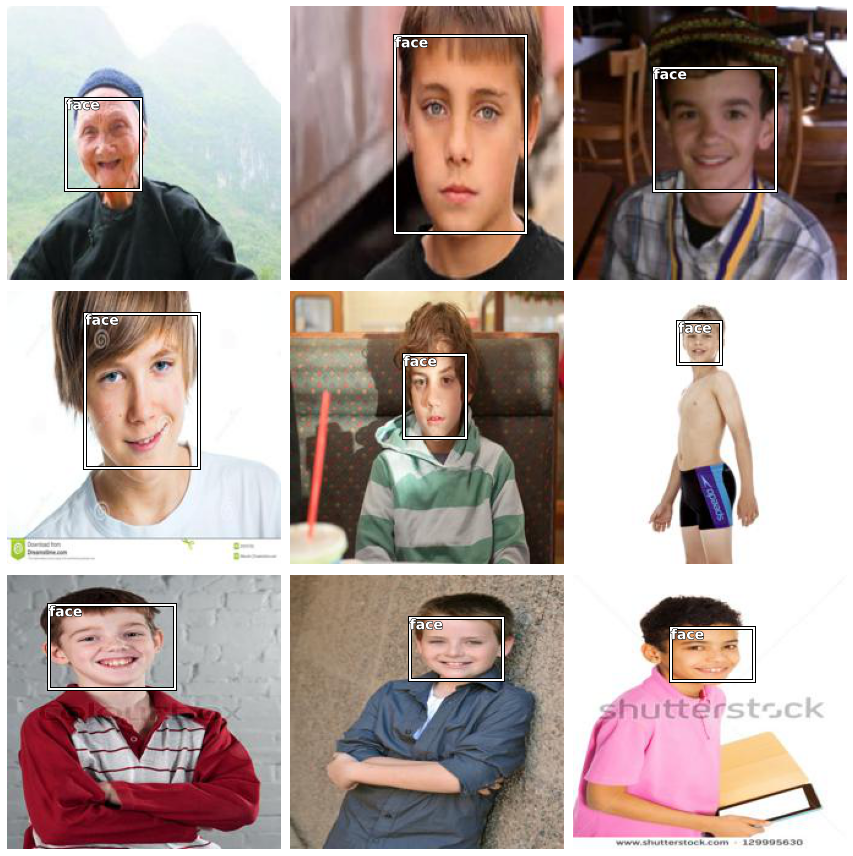

In [20]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

## TRAINING MODEL

In [21]:
class FaceDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [22]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [23]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [24]:
def acc_detection(preds, targs, _):
    return IoU(preds, targs.squeeze()).mean()

In [25]:
metrics = acc_detection

In [26]:
learn = Learner(data, FaceDetector(arch=models.resnet50),metrics=metrics, loss_func=loss_fn)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [27]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

Learner(data=ImageDataBunch;

Train: LabelList (1366 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: StubbedObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /content/train-224;

Valid: LabelList (200 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: StubbedObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /content/train-224;

Test: None, model=FaceDetector(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequ

In [28]:
learn.freeze_to(-1)

In [29]:
learn.fit_one_cycle(25, 1e-2, div_factor=12, pct_start=0.2)

epoch,train_loss,valid_loss,acc_detection,time
0,0.498315,0.557483,0.075030,00:19
1,0.425829,0.346794,0.285517,00:16
2,0.332640,0.185969,0.478414,00:16
3,0.270168,0.152136,0.536208,00:16
4,0.228505,0.157066,0.501267,00:16
5,0.202925,0.187360,0.513657,00:16
6,0.181196,0.186962,0.469817,00:17
7,0.165622,0.110929,0.626477,00:17
8,0.159864,0.316677,0.379407,00:17
9,0.159833,0.182696,0.494467,00:17


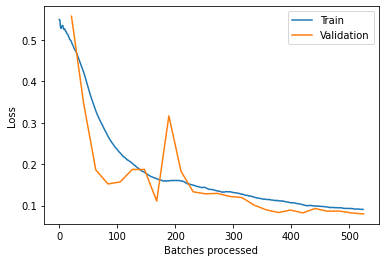

In [30]:
learn.recorder.plot_losses()

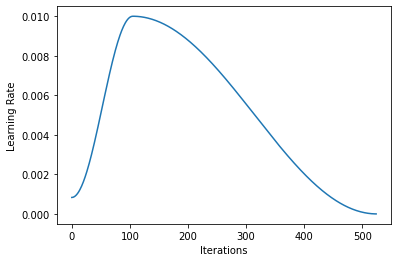

In [31]:
learn.recorder.plot_lr()

In [32]:
learn.unfreeze()

In [33]:
max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [34]:
learn.fit_one_cycle(40, lrs)

epoch,train_loss,valid_loss,acc_detection,time
0,0.085656,0.086207,0.721403,00:21
1,0.086058,0.080966,0.730166,00:21
2,0.087473,0.078182,0.730682,00:20
3,0.087295,0.074529,0.743937,00:20
4,0.087237,0.077904,0.740561,00:20
5,0.086394,0.082714,0.725999,00:21
6,0.085985,0.084724,0.712629,00:20
7,0.085414,0.093218,0.710476,00:20
8,0.087184,0.093946,0.706414,00:20
9,0.087021,0.095414,0.703372,00:20


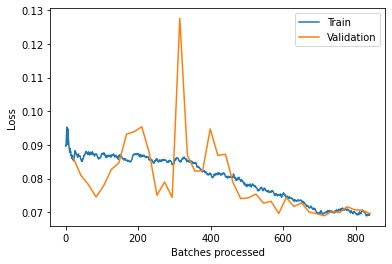

In [35]:
learn.recorder.plot_losses()

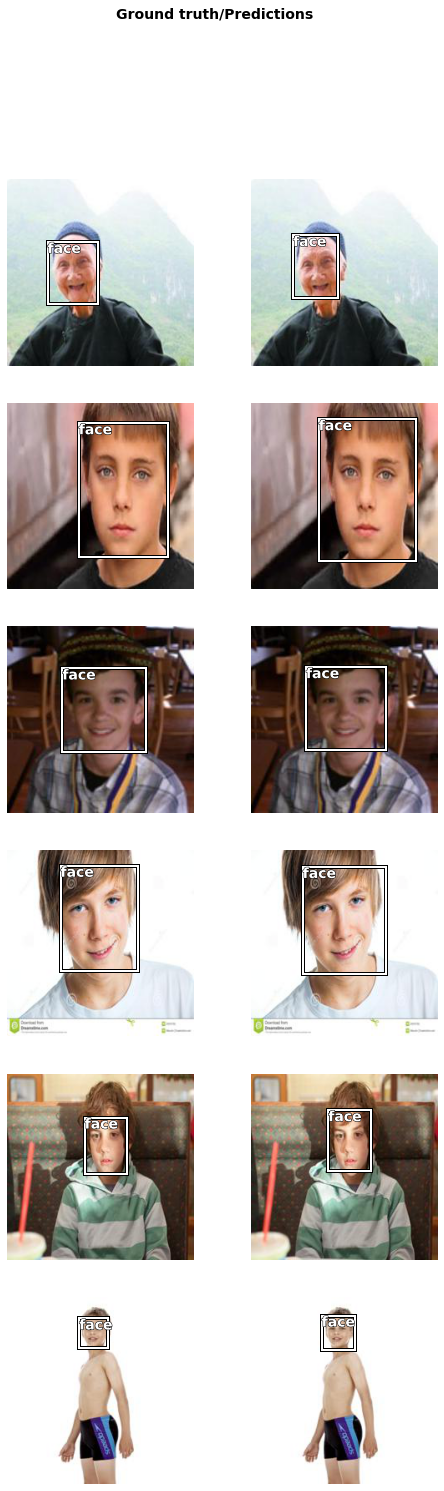

In [36]:
learn.show_results(rows=6)


In [37]:
learn.export('facedetect.pkl')

In [38]:
!cp /content/train-224/facedetect.pkl '/content/facedetec.pkl'

In [ ]:
from IPython.display import FileLink
FileLink('facedetection.pkl')

In [ ]:
# Return bbdoxs to orginal
#predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
#targets = ((targs + 1) / 2 * SZ).numpy().squeeze() comapre with ground truth

In [43]:
def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
     y_min, x_min, y_max, x_max = map(int, bbox)
     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
     #if target is not None:
     #    y_min, x_min, y_max, x_max = map(int, target)
     #    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
     return img

In [40]:
def cv_read(path):    
  im = cv2.imread(path, cv2.IMREAD_COLOR)
  return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Evaluate one image


In [ ]:
learn = load_learner(path)

NameError: ignored

In [ ]:
img = open_image('/content/mtrong.jpg')
img

NameError: ignored

In [ ]:
size_image,pred_idx,preds= learn.predict(img)

In [ ]:
predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()

In [ ]:
preds

In [ ]:
!cp /content/mtrong.jpg '/content/train-224/test/mtrong.jpg'

In [ ]:
a = PIL.Image.open('/content/drive/MyDrive/FaceDetection/mtrong.jpg').resize((224,224), resample=PIL.Image.BICUBIC).save('/content/mtrong.jpg')

In [ ]:
ims = np.stack([draw_bbox(cv_read('/content/mtrong.jpg'), predicted_bboxes)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [ ]:
learn.export()

In [ ]:
!cp /content/drive/MyDrive/FaceDetection/part1/val_fns_detection.pkl '/content/drive/MyDrive/FaceDetection/val_fns_detection.pkl'


## Evaluate on test set


In [ ]:
test = ObjectItemList.from_folder(p/'test')

In [ ]:
test

ObjectItemList (11 items)
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /content/train-224/test

In [ ]:
learn = load_learner(path,test=test,tfm_y=False)


In [ ]:
preds,targets = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
learn.export("facedetection.pkl")

In [ ]:
!cp /content/train-224/facedetection.pkl 'facedetection.pkl'


In [ ]:
from IPython.display import FileLink
FileLink('facedetection.pkl')

/content/facedetection.pkl

## EVALUEATE ON VALID

In [41]:
preds, targs = learn.get_preds()

In [42]:
predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
targets = ((targs + 1) / 2 * SZ).numpy().squeeze()

In [44]:
def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
     y_min, x_min, y_max, x_max = map(int, bbox)
     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
     if target is not None:
         y_min, x_min, y_max, x_max = map(int, target)
         cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
     return img

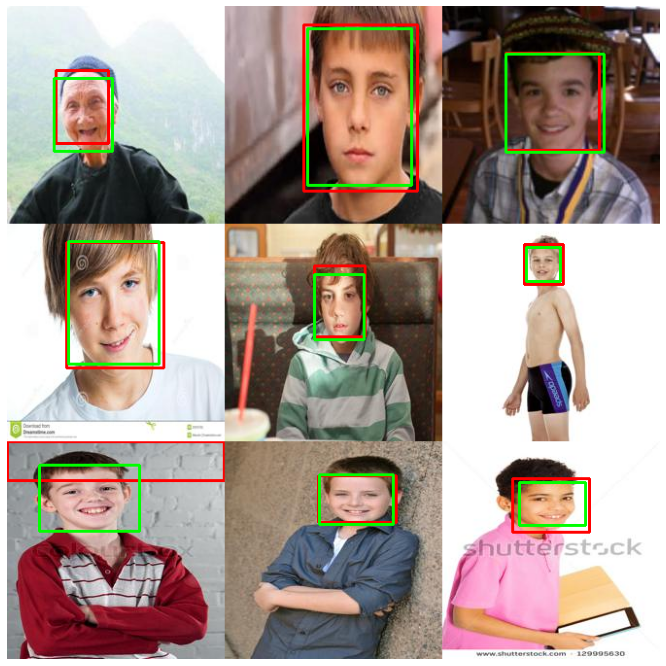

In [45]:
ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))